
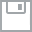
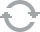
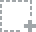
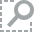
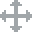
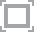
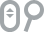
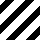
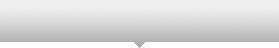
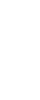
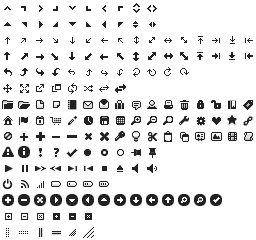
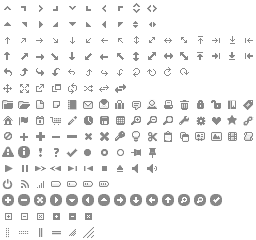
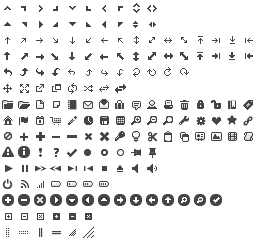
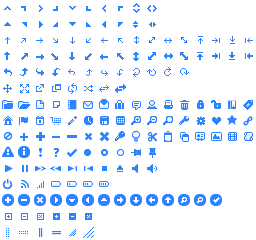
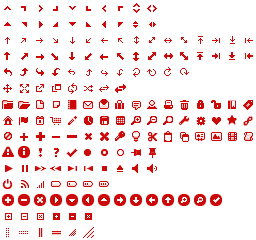
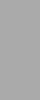
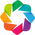
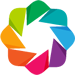

In [150]:
import pandas as pd
import numpy as np
import datetime as dt
import dill, wget
from geopy import geocoders   # geocoding by search address
import geocoder
import os, simplejson, requests
from pandas.io.json import json_normalize
from sqlalchemy import create_engine, sql # database connection
from collections import OrderedDict
from time import sleep    # time delay
from __future__ import division   # force float division
from IPython.display import display

from sklearn import cross_validation, grid_search
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, partial_dependence
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split, ShuffleSplit

from bokeh.plotting import figure, vplot, hplot
from bokeh.embed import components
from bokeh.charts import Bar, output_file, show, Histogram, Scatter
from bokeh.palettes import YlOrRd9 as palette
from bokeh.io import output_notebook, vform
from bokeh.models import CustomJS, ColumnDataSource, HoverTool
from bokeh.models.widgets import TextInput, CheckboxButtonGroup, RadioButtonGroup, Dropdown, Select, Panel, Tabs

%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

output_notebook()

In [5]:
# Initialize database obtained through API (NYC_Restaurant_Inspection_API.db) in current directory
disk_engine = create_engine('sqlite:///NYC_Restaurant_Inspection_API.db') 
# Initialize database with filename NYC_Restaurant_Inspection_web.db in current directory to store analyzed results
# for fast access when building websites
disk_output = create_engine('sqlite:///NYC_Restaurant_Inspection_web.db') 

# Define function for Preprocessing Data Consistently

We only use data from 2013-2015. df0 is the subset that only includes "Cycle Inspections" & "Pre-permit Inspections"

In [6]:
def preprocessing(df):
    if 'BORO' in df.columns:
        df = df[df.BORO != 'Missing']
        df.loc[:,'BORO']=df['BORO'].astype(str) 
    if 'INSPECTION_DATE' in df.columns:
        #convert Inspection date to datetime
        df.loc[:,'Date'] = pd.to_datetime(df['INSPECTION_DATE'])
        df = df.drop('INSPECTION_DATE', 1)
        #add Year column
        df.loc[:,'Year'] = df.Date.dt.year
        #only use 2012-2015 datasets
        df = df[df.Year >=2012]
    if 'CUISINE_DESCRIPTION' in df.columns:
        #fix the unicode for easier processing
        fix1=df['CUISINE_DESCRIPTION'].str.replace(u'CafÃ©/Coffee/Tea','Cafe/Coffee/Tea')
        fix2=fix1.str.replace(u'Café/Coffee/Tea','Cafe/Coffee/Tea')
        fix3=fix2.apply(lambda x: 'Latin' if str(x).startswith('Latin') else str(x) )
        df.loc[:,'Cuisine']=fix3.astype(str) 
        df=df.drop('CUISINE_DESCRIPTION',axis=1)
    #replace NaN with 'None'
    if 'GRADE' in df.columns:
        df.loc[:,'GRADE']=df.GRADE.fillna('None')
    if 'VIOLATION_CODE' in df.columns:
        df.loc[:,'VIOLATION_CODE']=df.VIOLATION_CODE.fillna('None')
        df.loc[:,'VIOLATION_CODE']=df['VIOLATION_CODE'].astype(str) 
    if 'SCORE' in df.columns:
        df.loc[:,'SCORE']=df.SCORE.fillna('None')
    if 'GRADE_DATE' in df.columns:
        df.loc[:,'GRADE_DATE']=df.GRADE_DATE.fillna('None')
   
    df.loc[:,'INSPECTION_TYPE']=df.INSPECTION_TYPE.fillna('None')
    df = df[df.INSPECTION_TYPE!='None']
    dft = df
    # for df, df0 only use 2013-2015 data
    df = df[df.Year>=2013]
    # data only from "Cycle Inspections" & "Pre-permit (Operational) Inspections"
    df0=df[df.INSPECTION_TYPE.str.startswith('Cycle')|
           (df.INSPECTION_TYPE.str.startswith('Pre')&df.INSPECTION_TYPE.str.contains('Operational'))]
    return df, df0, dft
    

# VI Machine Learning - Data Cleaning and Feature Construction

## VI.1 - Data Cleaning

In [10]:
drml = pd.read_sql_query('SELECT CAMIS, DBA, BUILDING, STREET, BORO, ZIPCODE, CUISINE_DESCRIPTION, '
                         'GRADE, SCORE, INSPECTION_DATE, INSPECTION_TYPE FROM data', disk_engine)

# dml0: Cycle & Pre-permit inspections from 2013 to 2015
dml, dml0, dmlt = preprocessing(drml)

#inspections with valid scores
dml_vscore = dml0[dml0.SCORE !='None']
#convert scores to int
dml_vscore.loc[:,'SCORE'] = dml_vscore.SCORE.astype(int)
#convert building and street to str type
dml_vscore.loc[:,'BUILDING'] = dml_vscore.BUILDING.str.strip()
dml_vscore.loc[:,'STREET'] = dml_vscore.STREET.str.strip()
#make address
dml_vscore.loc[:,'Address'] = dml_vscore.BUILDING+' '+dml_vscore.STREET+', '+dml_vscore.BORO+', NY'+' '+dml_vscore.ZIPCODE
#rename columns
dml_vscore.columns = ['CAMIS','DBA','building','street','boro','zipcode','grade','score',
                      'inspectype','date','year','cuisine','address']
#drop year column and getting unique entry from each inspection for each unique restaurant
dml_vscore = dml_vscore.drop('year',1).drop_duplicates(['CAMIS','date'])

## VI.2 - Feature Construction

## VI.2.1 - Data selection (those restaurants that have long enough score history)

In [11]:
#The number of restaurants
dml_vscore.groupby('CAMIS').count().shape

(24470, 11)

In [14]:
#list the CAMIS of those restaurants that have had at least 3 inspection grades
#first, get the most recent 3 entries that have a valid grade in it for each restaurant
dml_s = dml_vscore.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(3))
#count the number of entries found for each restaurant
dml_sc = dml_s.groupby('CAMIS').count()

#make a list of restaurants that had long enough score history to be studied
mlset = dml_sc[dml_sc.DBA>=3].reset_index().CAMIS.tolist()

#select data for these restaurants
dml_r = dml_vscore[dml_vscore.CAMIS.isin(mlset)]

## VI.2.2 - Target (Initial inspection score and final grade in the latest finished inspection cycle)

In [ ]:
# pick out the lastest final grade for each restaurant
# and start building the features table
features=dml_r.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(1)).set_index('CAMIS')

# build a dictionary of the latest final grade date for each restaurant
fg_date = features.date.to_dict()

def date_prune(df,date_dic):
    x = df.iloc[0,0]
    if x in date_dic:
        return df[df.date <= date_dic[x]]
    
# get rid of incomplete inspections that happen after the lastest complete inspection cylces
dml_ri = dml_r.groupby('CAMIS').apply(lambda x: date_prune(x, fg_date))
# get the initial inspections from the latest finished inspection cycle
dml_id = dml_ri.groupby('CAMIS').apply(lambda x: x[x.inspectype.str.contains('Initial')].head(1)).set_index('CAMIS')
# dates for the initial inspections from the latest finished inspection cycle
fis_date = dml_id.date.to_dict()

# assign these initial inspection scores to features as another target
features.loc[:,'i_score']=dml_id.score

## VI.2.3 - Construct score history features

In [ ]:
#Now that we finished constructing the targets, get rid of lastest complete inspection cycles
#another date pruning function, this time use "<"
def date_prune2(df,date_dic):
    x = df.iloc[0,0]
    if x in date_dic:
        return df[df.date < date_dic[x]]
    
#we are left with only score history before the most recent inspection cycles
dml_sh = dml_ri.groupby('CAMIS').apply(lambda x: date_prune2(x, fis_date)).set_index('CAMIS')

#for all non-inital inspections, assign "Re" label
def inspec_type(x):
    if "Initial" in x:
        return "Ini"
    else:
        return "Re"
    
dml_sh.loc[:,'label']=dml_sh.inspectype.map(inspec_type)
dml_sh=dml_sh.reset_index()

### VI.2.3.1 - Calculate the lapse and correction rate

In [ ]:
#calculate the average of lapse (initial score - previous final score) 
#and the average of compliance (Reinspection score - previous score)
#First get the differences between each inspection
dml_rate = dml_sh.groupby('CAMIS').apply(lambda x: x.set_index('label')['score'].diff(-1).to_frame().reset_index())
dml_rate= dml_rate.reset_index('CAMIS')

#Then calcuate the average
dml_ar = dml_rate.groupby(['CAMIS','label']).apply(np.mean).unstack(level=-1)

#Assign the average lapse and corrections scores to features dataframe
features.loc[:,'lapse']=dml_ar['score','Ini']
features.loc[:,'correction']=dml_ar['score','Re']
#For restaurants without Re-inspections use 0 as the correction score
features['correction'].fillna(0, inplace=True)

### VI.2.3.2 - Whether there has been a compliance or reopening inspection in history

In [42]:
def find_com(df):
    li = df.inspectype.tolist()
    for item in li:
        if 'Compliance' in item or 'Reopening' in item:
            return 1
            break
    else:
        return 0
    
features.loc[:,'com/reopen'] = dml_sh.groupby('CAMIS').apply(find_com)

### VI.2.3.3 - Initial inspection score and final score in the recent inspection cycle

In [45]:
#get final score
features.loc[:,'sh_fscore']=dml_sh.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(1)).set_index('CAMIS').score
#get final grade
features.loc[:,'sh_fgrade']=dml_sh.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(1)).set_index('CAMIS').grade
#get initial inspection score
features.loc[:,'sh_iscore']=dml_sh.groupby('CAMIS').apply(lambda x: x[x.inspectype.str.contains('Initial')].head(1)).set_index('CAMIS').score

features = features.drop('inspectype',1)
features.loc[:,'cuisine'] = features.cuisine.map(lambda x: x.strip())

## VI.2.4 - Convert zipcodes to latitudes and longitudes

In [253]:
Xy = features[['sh_iscore','sh_fscore','com/reopen','lapse','correction','cuisine','zipcode','date','i_score','score']]
#get rid of missing data in lapse column (only two rows eliminated)
Xy = Xy.dropna()
#create month column
Xy.loc[:,'month'] = Xy.date.map(lambda x: x.month)

y = Xy[['i_score','score']]
X = Xy[['sh_iscore','sh_fscore','com/reopen','lapse','correction','cuisine','zipcode','month']]

#load zipcode database for converting zipcode to latln for the centroid
dzip = pd.read_csv('zipcode.csv')[['zip','latitude','longitude']]
dzip.columns = ['zipcode','latitude','longitude']

#get all zipcodes
zipcodes = list(set(X.zipcode.tolist()))

#constructing zipcode: lat, lng dictionary
zip_dic={}
for z in zipcodes:
    latlng = geocoder.google(str(z)+', US').latlng
    zip_dic.update({z: latlng})
    sleep(1)
    
#making a zipcode - latlng dataframe
zip_latlng = pd.DataFrame(zip_dic).T.reset_index()
zip_latlng.columns = ['zipcode','latitude','longitude']
zip_latlng.head()

,zipcode,latitude,longitude
0,10001,40.753685,-73.999164
1,10002,40.713510,-73.985941
2,10003,40.732253,-73.987410
3,10004,40.703870,-74.013854
4,10005,40.699843,-74.007244


In [366]:
#save the zipcode - latlng information for future convenience
dill.dump(zip_latlng, open('zip_latlng','w'))

In [51]:
#merge with X on zipcodes
X.loc[:,'zipcode']=X.zipcode.astype(int)
X = pd.merge(X.reset_index(), zip_latlng, how='left', on='zipcode')
X.head()

,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,month,latitude,longitude
0,30075445,2,2,0,9,-26.0,Bakery,10462,2,40.838252,-73.856609
1,30112340,16,8,0,-3,1.0,Hamburgers,11225,5,40.664828,-73.956555
2,30191841,2,2,0,-9,0.0,Irish,10019,9,40.768697,-73.991818
3,40356018,5,5,0,-2,0.0,American,11224,6,40.574926,-73.985941
4,40356151,19,16,0,26,-21.5,American,11369,5,40.765925,-73.868370


# VII Machine Learning - Models

## VII.1 Random forest

In [75]:
Xs=X[['sh_iscore', 'sh_fscore', 'com/reopen', 'lapse', 'correction', 'latitude', 'longitude', 'month']]
# initial score and final score as target
yy = y.as_matrix()
yi = yy[:,0]
yf = yy[:,1]

In [76]:
#build a transformer for cuisine
class CuisineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        # initialization code
        self.key = key

    def fit(self, X, y=None):
        # fit the transformation
        return self

    def transform(self, X):
        if type(X)==str:
            #if cuisine is in the cuisine list
            if X in self.categories:
                self.XX = {X: 1}
            #if not, assign 0 to all cuisine types
            else:
                self.XX = {item: 0 for item in self.categories}
        else:
            #create a list of cuisines
            self.categories = list(set(X[self.key].tolist()))

            # transform the data from pandas dataframe to list of dictionaries
            self.XX = X[self.key].map(lambda x: {x: 1}).tolist() 
            
        return self.XX 
    
class Sh_Latlng_month_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        # initialization code
        self.key = key

    def fit(self, X, y=None):
        # fit the transformation
        return self

    def transform(self, X):
        if type(X)==dict:
            self.li=[]
            for k in self.key:
                self.li.append(X[k])
            self.df = [self.li]
        else:
            self.df = X[self.key].as_matrix()
        return self.df # transformation
    
    
#Random Forest
class rf_model(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        param_grid = { "n_estimators": range(300, 600, 100), "min_samples_leaf": range(10, 100, 20) }    
        self.random_forest_cv = grid_search.GridSearchCV(RandomForestRegressor(warm_start=True), 
                                                       param_grid=param_grid, 
                                                       scoring='mean_squared_error',n_jobs=-1)
        self.random_forest_cv.fit(X, y)
        return self
    
    def predict(self, X):
        self.tmp = self.random_forest_cv.predict(X)
        if len(self.tmp) ==1:
            self.result = self.tmp[0]
        else:
            self.result = self.tmp
        return self.result

In [77]:
featureunion = FeatureUnion(transformer_list=[('cuisine', Pipeline([('trans', CuisineTransformer('cuisine')),
                                                                    ('vect', DictVectorizer())
                                                                   ])),
                                              ('other', Sh_Latlng_month_Transformer(['sh_iscore',
                                                                                     'sh_fscore', 
                                                                                     'com/reopen', 
                                                                                     'lapse',
                                                                                     'correction',
                                                                                     'latitude',
                                                                                     'longitude',
                                                                                     'month']))
                                             ])

In [ ]:
rfmodel = Pipeline([('featureunion', featureunion), ('est', rf_model())])

#fullmodel fits initial score and final score at the same time
rfmodel.fit(X,yy)

### VII.1.1 - Random forest: feature importance

In [70]:
# get the best estimator from the random forest model
best_est=rfmodel.named_steps['est'].random_forest_cv.best_estimator_

feature_imp = best_est.feature_importances_
# cuisines ends at 83
cuisine_imp = feature_imp[:83]
cuisine_name = sorted(list(set(X.cuisine.tolist())))
cfimp = pd.DataFrame(zip(cuisine_name,cuisine_imp),columns=['feature','importance'])
cfimp = cfimp[cfimp.importance!=0]
cfimp.loc[:,'feature']=cfimp.feature.map(lambda x: x+" (cuisine)")

# other features besides cuisine type
other_imp = feature_imp[83:]
other_name = ['Previous initial score','Previous final score', 'com/reopen', 'lapse','correction','latitude','longitude','month']
ofimp = pd.DataFrame(zip(other_name, other_imp),columns=['feature','importance'])
ofimp

,feature,importance
0,Previous initial score,0.209359
1,Previous final score,0.136641
2,com/reopen,0.005818
3,lapse,0.061764
4,correction,0.065043
5,latitude,0.050304
6,longitude,0.039991
7,month,0.415317


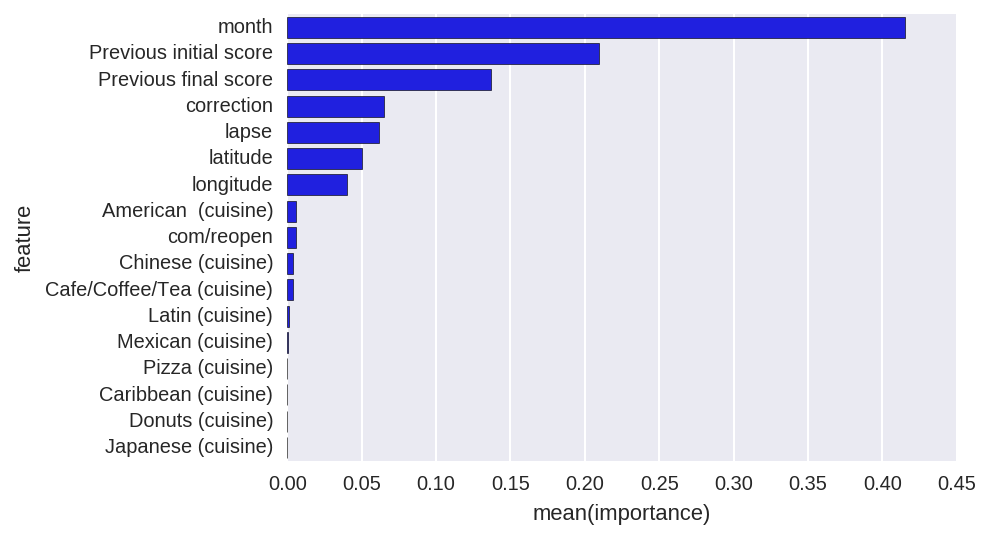

In [129]:
sns.barplot(x="importance",y="feature", data=fi, color="blue")

From the feature importance, the cuisine types seem to have very little influence on the model predictions.

### VII.1.2 - Seasonal plot

In [135]:
#generate dataframe for 12 month
var = {'cuisine': 'Chinese','sh_iscore': 30, 'sh_fscore': 10, 'com/reopen': 1, 'lapse': 5,'correction':-10,
       'zipcode': 10011}
vardf = pd.DataFrame(var, index=[0])
#geocode zipcodes
vardf = pd.merge(vardf, zip_latlng, how='left', on='zipcode')
#add month
vardf12 = pd.concat([vardf]*12)
vardf12.loc[:,'month']=np.array(range(1,13))

#predict scores using the model
p_scores = pd.DataFrame(fullmodel.predict(vardf12),columns=['iscore','fscore'])
p_scores.loc[:,'month'] = np.array(range(1,13))

In [136]:
# plot score vs month
width = 800
height = 350
plot = figure(width=width, height=height,
                  # tools=TOOLS,
                  title='Score variation with time (from model)',
                  x_axis_label='Month of year')

# numlines = len(options)
# colors=[]
options = ['iscore','fscore']
colorselect = dict([('iscore', 'red'), ('fscore', 'green')])
leg = dict(
        [('iscore', 'Initial inspection score'),
         ('fscore', 'Final score')])

for item in options:
    plot.circle(
            x=p_scores.month,
            y=p_scores[item],
            size=10,
            fill_color="white",
            line_color=colorselect[item],
            legend=leg[item],
            line_width=3)
    plot.line(
            x=p_scores.month,
            y=p_scores[item],
            line_color=colorselect[item],
            legend=leg[item])

plot.legend.orientation = "top_left"
plot.legend.legend_padding = 40

show(plot)

## VII.2 - Gradient boosted trees for partial dependence analysis

In [139]:
Xs=X[['sh_iscore', 'sh_fscore', 'com/reopen', 'lapse', 'correction', 'latitude', 'longitude', 'month']]
yy = y.as_matrix()
yi = yy[:,0]
yf = yy[:,1]

In [140]:
#Gradient boost
class gb_model(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        param_grid = {"min_samples_leaf": [6], "max_depth":[8], "learning_rate":[0.0005]}   
        self.gb_cv = grid_search.GridSearchCV(GradientBoostingRegressor(warm_start=True,loss='ls', n_estimators=1500), 
                                                       param_grid=param_grid, 
                                                       scoring='mean_squared_error')
        self.gb_cv.fit(X, y)
        return self
    
    def predict(self, X):
        self.tmp = self.gb_cv.predict(X)
        if len(self.tmp) ==1:
            self.result = self.tmp[0]
        else:
            self.result = self.tmp
        return self.result

In [141]:
gbmodel = Pipeline([ ('other', Sh_Latlng_month_Transformer(['sh_iscore','sh_fscore', 'com/reopen', 
                                                               'lapse','correction','latitude',
                                                               'longitude','month'])), ('est', gb_model())])

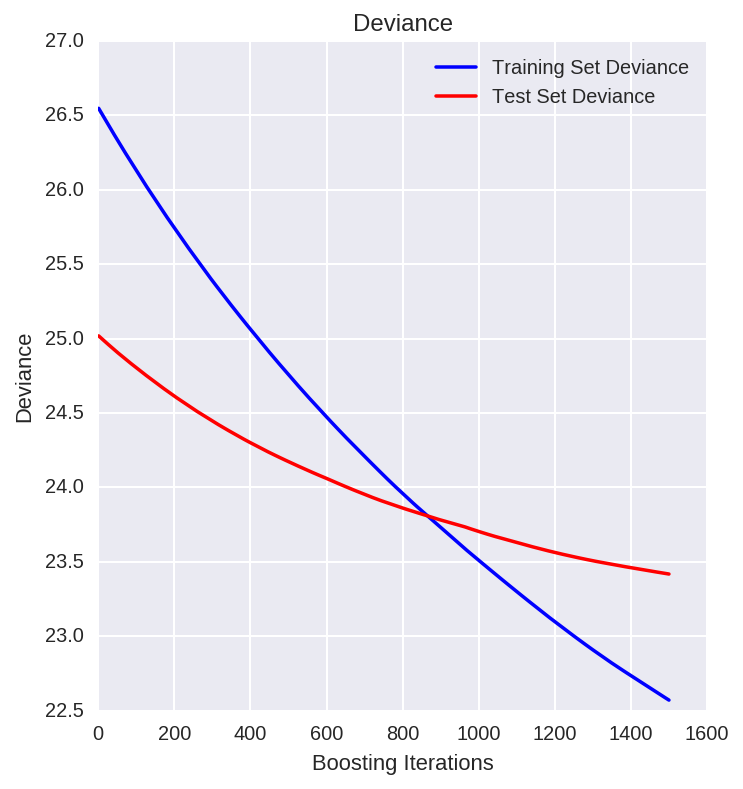

In [146]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(Xs, yf, test_size=0.33, random_state=12)

gbmodel.fit(X_train,y_train)

best_est = gbmodel.named_steps['est'].gb_cv.best_estimator_

# Plot training deviance
clf = best_est
ra = 1500
# compute test set deviance
test_score = np.zeros((ra,), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(ra) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(ra) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



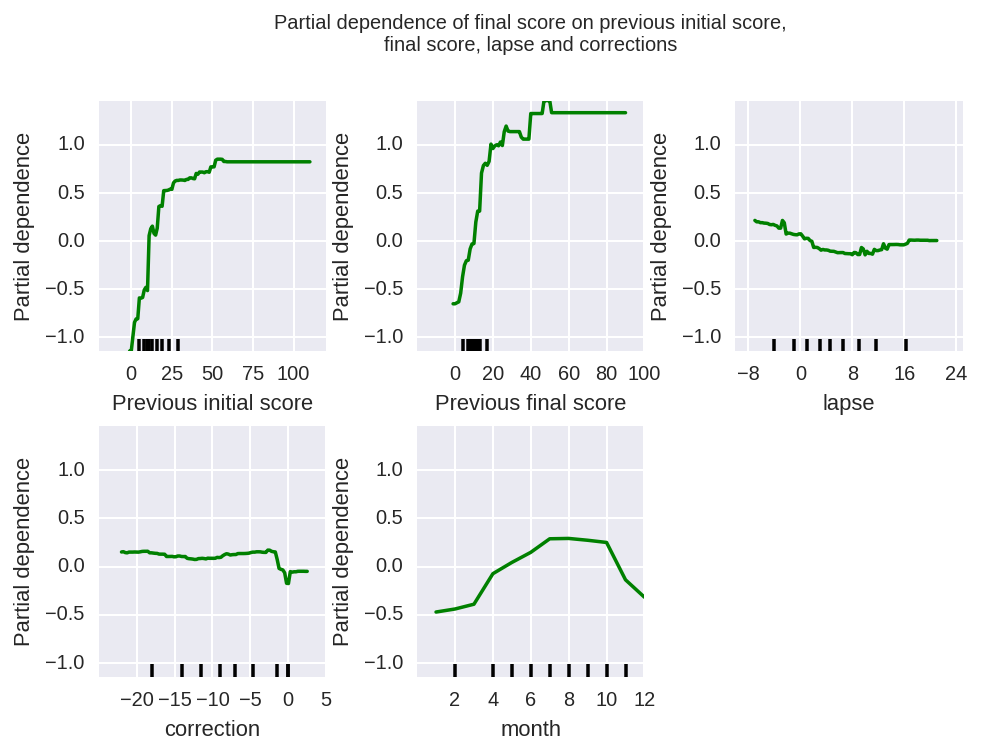

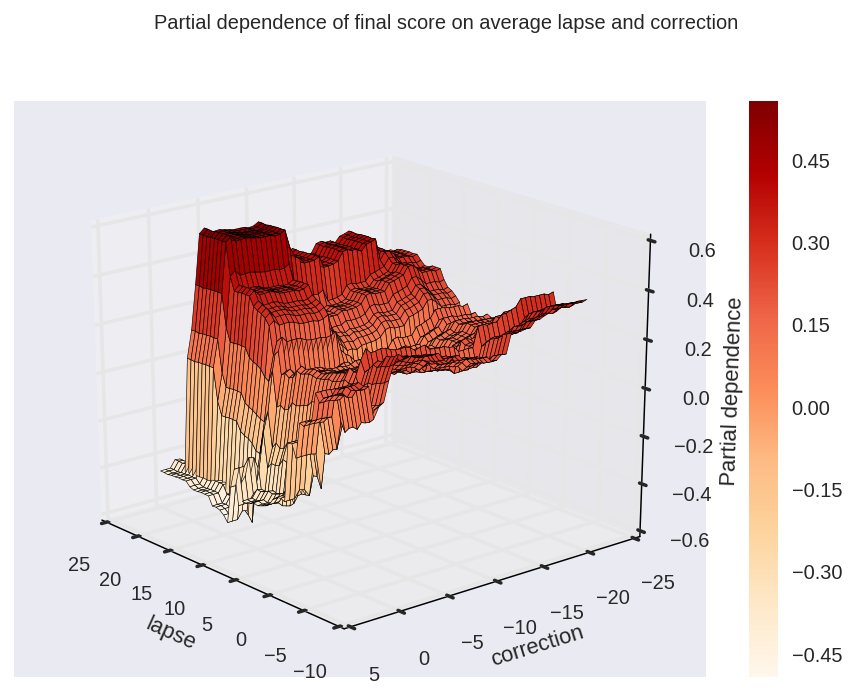

In [156]:
features = [0, 1, 3, 4, 7]
names = ['Previous initial score','Previous final score', 'com/reopen', 'lapse','correction','latitude','longitude','month']
fig, axs = partial_dependence.plot_partial_dependence(best_est, Xs, features, feature_names=names, n_jobs=-1)
fig.suptitle('Partial dependence of final score on previous initial score,\n'
             'final score, lapse and corrections',y=1.15)
plt.subplots_adjust(bottom=0,left=0.0, right=1.0, top=1.0)  # tight_layout causes overlap with subtitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (3, 4)
pdp, (x_axis, y_axis) = partial_dependence.partial_dependence(best_est, target_feature, X=Xs, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.OrRd)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=140)
plt.colorbar(surf)
plt.suptitle('Partial dependence of final score on average lapse and correction',y=1.15)
plt.subplots_adjust(top=0.9)

plt.show()

________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



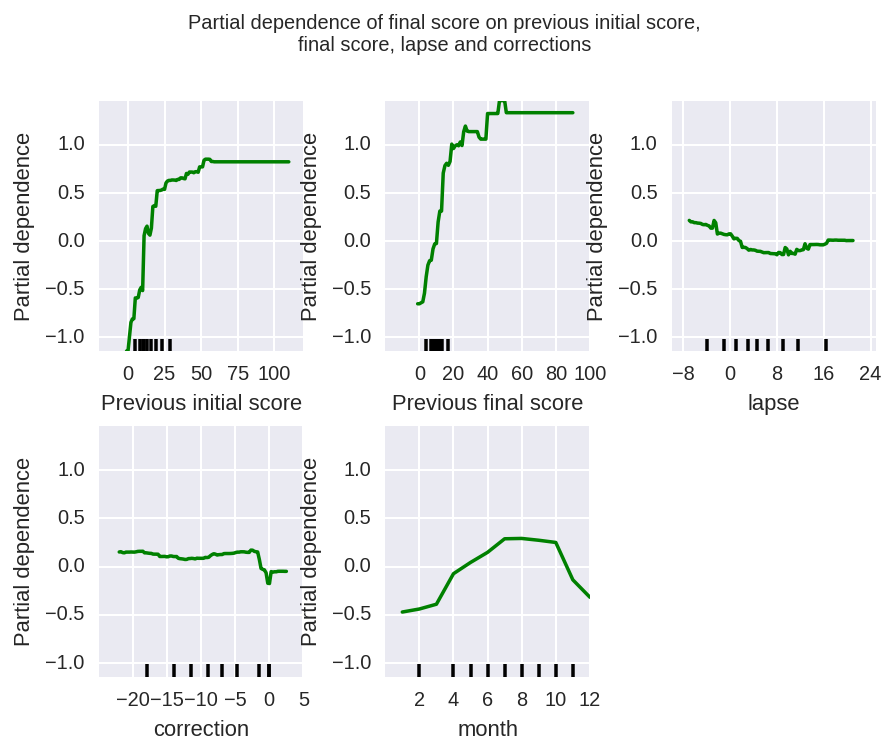

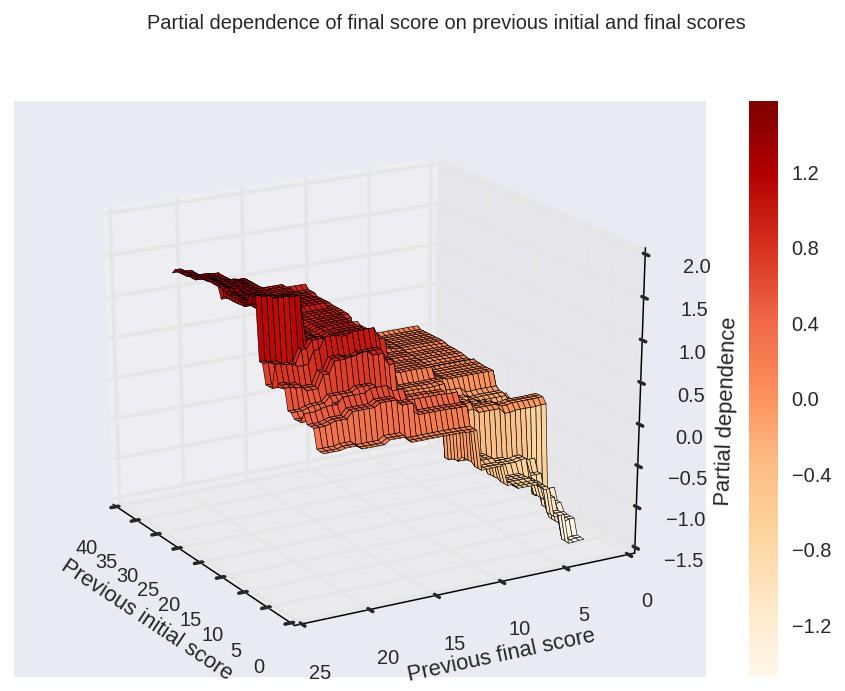

In [157]:
features = [0, 1, 3, 4, 7]
names = ['Previous initial score','Previous final score', 'com/reopen', 'lapse','correction','latitude','longitude','month']
fig, axs = partial_dependence.plot_partial_dependence(best_est, Xs, features, feature_names=names, n_jobs=-1)
fig.suptitle('Partial dependence of final score on previous initial score,\n'
             'final score, lapse and corrections',y=1.15)
plt.subplots_adjust(bottom=0, right=1.0, top=1.0)  # tight_layout causes overlap with subtitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (0, 1)
pdp, (x_axis, y_axis) = partial_dependence.partial_dependence(best_est, target_feature, X=Xs, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.OrRd)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=150)
plt.colorbar(surf)
plt.suptitle('Partial dependence of final score on previous initial and final scores',y=1.15)
plt.subplots_adjust(top=0.9)

plt.show()

## Appendix 1: additional analysis - Gradient boosted trees for each cuisine type

This part includes additional analysis using gradient boosted trees algorithm for each cuisine type. This is not presented on the website.

In [96]:
# top 22 cuisines
top22 = features.groupby('cuisine').count().sort_values('DBA',ascending=False).head(22).index.tolist()

Fc = features[features.cuisine.isin(top22)]
Xyc = Fc[['sh_iscore','sh_fscore','com/reopen','lapse','correction','cuisine','zipcode','date','i_score','score']]
#get rid of missing data in lapse column (only two rows eliminated)
Xyc = Xyc.dropna()
#create month column
Xyc.loc[:,'month'] = Xyc.date.map(lambda x: x.month)

yc = Xyc[['cuisine','i_score','score']]
Xc = Xyc[['sh_iscore','sh_fscore','com/reopen','lapse','correction','cuisine','zipcode','month']]

#add latitude and longitude columns

zip_latlng=dill.load(open('zip_latlng','r'))
#merge with Xc on zipcodes
Xc.loc[:,'zipcode']=Xc.zipcode.astype(int)
Xc = pd.merge(Xc.reset_index(), zip_latlng, how='left', on='zipcode')

#inital score target
yci = yc[['cuisine','i_score']]
#rename columns
yci.columns=['cuisine','score']
#final score target
ycf = yc[['cuisine','score']]

#train test split
Xc_train, Xc_test, ycf_train, ycf_test = train_test_split(Xc, ycf, test_size=0.33, random_state=12)
Xc_train, Xc_test, yci_train, yci_test = train_test_split(Xc, yci, test_size=0.33, random_state=12)

In [91]:
#Gradient boost
class cgb_model(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        #cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
        self.cuisines = X.cuisine.unique().tolist()
        self.cv = {}
        for c in self.cuisines:
            Xcuisine = X[X.cuisine==c][['sh_iscore','sh_fscore', 'com/reopen', 
                                       'lapse','correction','latitude','longitude','month']].as_matrix()
            ycuisine = y[y.cuisine==c].score.tolist()
            param_grid = {"min_samples_leaf": [6], "max_depth":[8], "learning_rate":[0.0005]}   
            self.cv[c] = grid_search.GridSearchCV(GradientBoostingRegressor(warm_start=True,loss='ls', n_estimators=1500), 
                                                       param_grid=param_grid, 
                                                       scoring='mean_squared_error')
            self.cv[c].fit(Xcuisine, ycuisine)
        return self
    
    def predict(self, X):
        c = X.cuisine.tolist()[0]
        Xcuisine = X[X.cuisine==c][['sh_iscore','sh_fscore', 'com/reopen', 
                                       'lapse','correction','latitude','longitude','month']].as_matrix()
        self.tmp = self.cv[c].predict(Xcuisine)
        if len(self.tmp) ==1:
            self.result = self.tmp[0]
        else:
            self.result = self.tmp
        return self.result

In [92]:
#model targeting the final score
cgbmodel_f=cgb_model()
cgbmodel_f.fit(Xc_train, ycf_train)

cgb_model()

In [97]:
#model targeting the initial score
cgbmodel_i=cgb_model()
cgbmodel_i.fit(Xc_train, yci_train)

cgb_model()

### Appendix 1.1 - Gradient boosted trees: deviance plot

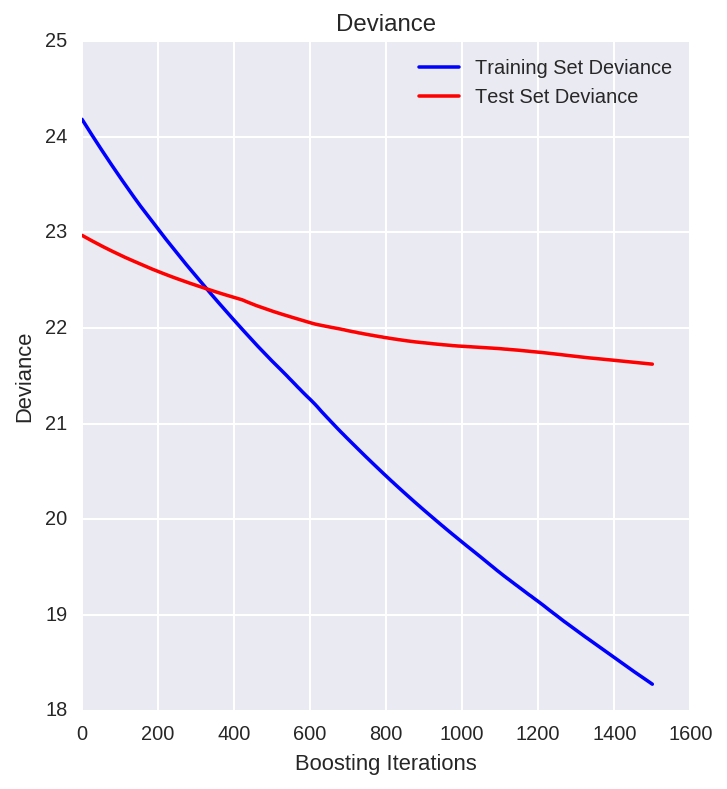

In [161]:
# Plot training deviance
# select cuisine model
cc = 'American'
# select whether to look at "i" or "f" model
s = cgbmodel_f

clf = s.cv[cc].best_estimator_
Xc_testc = Xc_test[Xc_test.cuisine == cc][['sh_iscore','sh_fscore', 'com/reopen', 
                                       'lapse','correction','latitude','longitude','month']]
ycf_testc = ycf_test[ycf_test.cuisine == cc].score.tolist()
ra = 1500
# compute test set deviance
test_score = np.zeros((ra,), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(Xc_testc)):
    test_score[i] = clf.loss_(ycf_testc, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(ra) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(ra) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

### Appendix 1.2 - Gradient boosted trees: feature importance

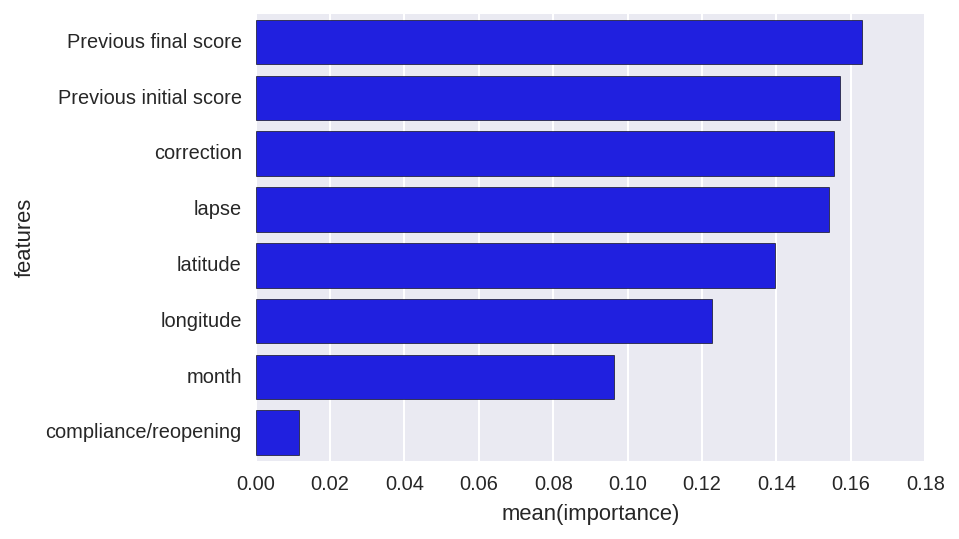

In [105]:
li = []
# select whether to look at the "i" or "f" model
s = cgbmodel_f

# list feature importance for all cuisine types
for c in s.cuisines:
    li.append(s.cv[c].best_estimator_.feature_importances_)
f_imp = pd.DataFrame(li,columns=['Previous initial score','Previous final score', 
                                 'compliance/reopening',
                                 'lapse', 'correction', 'latitude','longitude','month'])

#calculate the average feature importance
f_impa = f_imp.mean().to_frame().reset_index()
f_impa.columns = ['features','importance']
f_impa = f_impa.sort_values('importance',ascending=False)

sns.barplot(x="importance",y="features", data=f_impa, color="blue")

### Appendix 1.3- Seasonal plot

In [159]:
#generate dataframe for 12 month
var = {'cuisine': 'Chinese','sh_iscore': 30, 'sh_fscore': 10, 'com/reopen': 1, 'lapse': 5,'correction':-10,
       'zipcode': 10011}
vardf = pd.DataFrame(var, index=[0])
#geocode zipcodes
vardf = pd.merge(vardf, zip_latlng, how='left', on='zipcode')
#add month
vardf12 = pd.concat([vardf]*12)
vardf12.loc[:,'month']=np.array(range(1,13))

#predict scores using the model
p_scores = pd.DataFrame(cgbmodel_i.predict(vardf12),columns=['iscore'])
p_scores.loc[:,'month'] = np.array(range(1,13))
p_scores.loc[:,'fscore'] = cgbmodel_f.predict(vardf12)

In [160]:
# plot score vs month
width = 800
height = 350
plot = figure(width=width, height=height,
                  # tools=TOOLS,
                  title='Score variation with time (from model)',
                  x_axis_label='Month of year')

# numlines = len(options)
# colors=[]
options = ['iscore','fscore']
colorselect = dict([('iscore', 'red'), ('fscore', 'green')])
leg = dict(
        [('iscore', 'Initial inspection score'),
         ('fscore', 'Final score')])

for item in options:
    plot.circle(
            x=p_scores.month,
            y=p_scores[item],
            size=10,
            fill_color="white",
            line_color=colorselect[item],
            legend=leg[item],
            line_width=3)
    plot.line(
            x=p_scores.month,
            y=p_scores[item],
            line_color=colorselect[item],
            legend=leg[item])

plot.legend.orientation = "top_left"
plot.legend.legend_padding = 40

show(plot)